In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2
import re
import string
from textblob import TextBlob
import nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
df = pd.read_csv('train.csv')
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [5]:
df.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
count = df['label'].value_counts()
print(count)

label
0    29720
1     2242
Name: count, dtype: int64


<ipython-input-7-48ab07734105>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette={'0': 'blue', '1': 'maroon'})


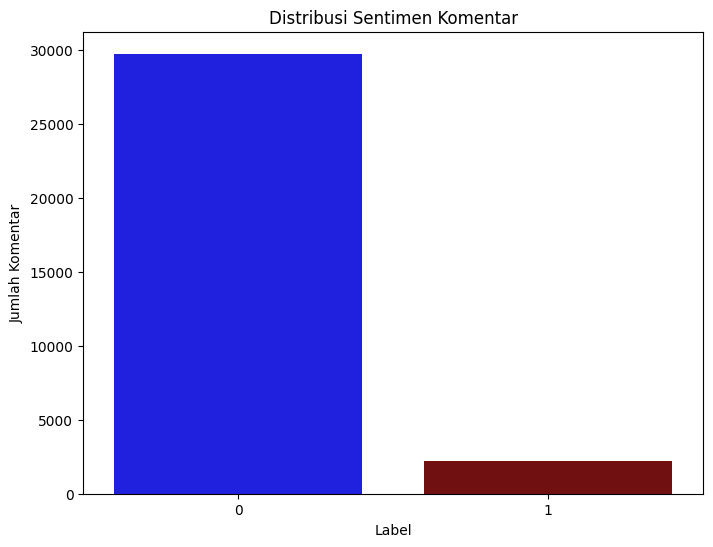

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette={'0': 'blue', '1': 'maroon'})
plt.title('Distribusi Sentimen Komentar')
plt.xlabel('Label')
plt.ylabel('Jumlah Komentar')
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [10]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove punctuation and numbers

    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])

    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

df['cleaned_tweet'] = df['tweet'].apply(clean_text)

In [11]:
df

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguide society motivation
...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,ate isz youuu
31958,31959,0,to see nina turner on the airwaves trying to...,see nina turner airwave trying wrap mantle gen...
31959,31960,0,listening to sad songs on a monday morning otw...,listening sad song monday morning otw work sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...",sikh temple vandalised calgary wso condemns act


In [12]:
vocab_size = 1000  # Jumlah kata maksimum dalam tokenizer
max_length = 15     # Panjang maksimal sequence
oov_token = "<OOV>"

In [13]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['cleaned_tweet'])

texts = df['cleaned_tweet'].values

In [14]:
import joblib
joblib.dump(tokenizer, "tokenizer.joblib")

['tokenizer.joblib']

In [15]:
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
padded_sequences

array([[ 15,   1,   1, ...,   0,   0,   0],
       [101,   1,   1, ...,   1,   0,   0],
       [ 18,   1,   0, ...,   0,   0,   0],
       ...,
       [942,  68, 252, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [100,  89,   0, ...,   0,   0,   0]], dtype=int32)

In [16]:
X = padded_sequences
y = df['label'].values

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [18]:
print("Hasil Pembagian Data:")
print(f"Jumlah data pelatihan: {X_train.shape[0]}")
print(f"Jumlah data validasi: {X_val.shape[0]}")

Hasil Pembagian Data:
Jumlah data pelatihan: 25569
Jumlah data validasi: 6393


In [19]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

Shape of X_train: (25569, 15)
Shape of X_val: (6393, 15)


In [20]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64),
    LSTM(64, return_sequences=True),
    Dropout(0.35),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
history = model.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])), y_train, epochs=10, validation_data=(np.reshape(X_val, (X_val.shape[0], X_val.shape[1])), y_val))

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - accuracy: 0.9305 - loss: 0.2440 - val_accuracy: 0.9462 - val_loss: 0.1561
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.9476 - loss: 0.1450 - val_accuracy: 0.9481 - val_loss: 0.1553
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.9518 - loss: 0.1304 - val_accuracy: 0.9465 - val_loss: 0.1539
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.9527 - loss: 0.1253 - val_accuracy: 0.9443 - val_loss: 0.1569
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9546 - loss: 0.1223 - val_accuracy: 0.9463 - val_loss: 0.1728
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.9571 - loss: 0.1171 - val_accuracy: 0.9357 - val_loss: 0.1699
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9591 - loss: 0.1107 - val_accuracy: 0.9473 - val_loss: 0.1651
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9623 - loss: 0.1016 - 

In [30]:
model.save('teks.keras')

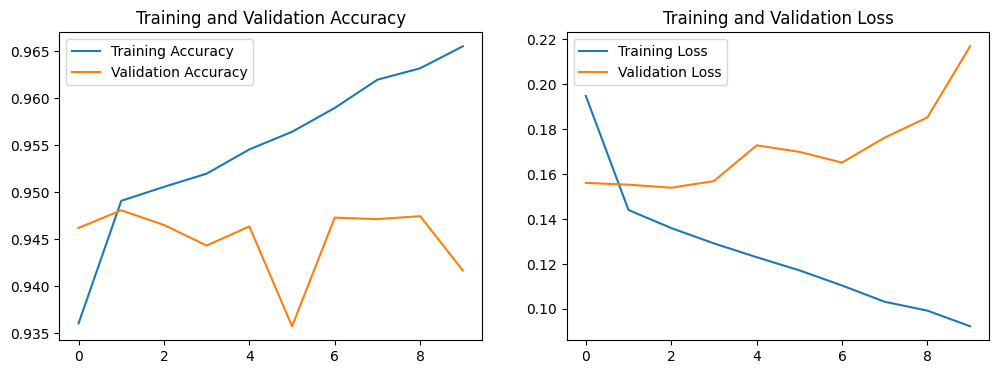

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 15, 64)              │       2,382,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 15, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,285,349 (27.79 MB)

 Trainable params: 2,428,449 (9.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,856,900 (18.53 MB)

In [26]:
loss, accuracy = model.evaluate(np.reshape(X_val, (X_val.shape[0], X_val.shape[1])), y_val)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9368 - loss: 0.2296
Validation Loss: 0.2168
Validation Accuracy: 94.17%


In [27]:
y_val_pred = model.predict(np.reshape(X_val, (X_val.shape[0], X_val.shape[1])))
y_val_pred = (y_val_pred > 0.5).astype(int)

print(classification_report(y_val, y_val_pred))

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5960
           1       0.58      0.50      0.54       433

    accuracy                           0.94      6393
   macro avg       0.77      0.74      0.75      6393
weighted avg       0.94      0.94      0.94      6393



In [29]:
df = pd.read_csv('test.csv')
new_texts = df['tweet'].tolist()

new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=10, padding='post')

predictions = model.predict(new_padded)

predicted_labels = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

results_df = pd.DataFrame({
    'tweet': new_texts,
    'predicted_label': predicted_labels
})

display(results_df)
results_df.to_csv('prediction_results.csv', index=False)


538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


,tweet,predicted_label
0,#studiolife #aislife #requires #passion #dedic...,negative
1,@user #white #supremacists want everyone to s...,negative
2,safe ways to heal your #acne!! #altwaystohe...,negative
3,is the hp and the cursed child book up for res...,negative
4,"3rd #bihday to my amazing, hilarious #nephew...",negative
...,...,...
17192,thought factory: left-right polarisation! #tru...,positive
17193,feeling like a mermaid ð #hairflip #neverre...,negative
17194,#hillary #campaigned today in #ohio((omg)) &am...,positive
17195,"happy, at work conference: right mindset leads...",negative
